In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
# from sklearn.manifold import TSNE
import sqlite3
import matplotlib.pyplot as plt
import nltk
from nltk.stem.porter import PorterStemmer
import re
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
# from sklearn import cross_validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
# df = pd.read_sql("SELECT * FROM TABLE",con)
con = sqlite3.connect('/home/rahul/Desktop/MLAAIC/database.sqlite')
df = pd.read_sql_query("""SELECT *
FROM Reviews
""",con)  

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Data Preprocessing

In [4]:
# df.Score.value_counts()
df = df.dropna()
# df.shape
# https://stac|koverflow.com/questions/19913659/pandas-conditional-creation-of-a-series-dataframe-column
df['review'] = np.where(df['Score']>3, 'positive', 'negative')
df.review.value_counts()

positive    443777
negative    124677
Name: review, dtype: int64

In [5]:
#i will be using only 10% of available data  
#this assignments
#https://stackoverflow.com/questions/38085547/random-sample-of-a-subset-of-a-dataframe-in-pandas
# sample = np.random.uniform(0,len(df),int(len(df)*0.10))
# df_sample = df.iloc[sample]
df_sample = df

#### removing duplicate copies 

In [6]:
sorted_data=df_sample.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
DataPoints, Features = final.shape
l= final["review"].unique()
x,y= final["review"].value_counts()
print("Final Data \n")
# print(len(l))
print ("Total number of Datapoints -",DataPoints,'\n\n'
      'Total Number Features or Independent Variable -',Features-1,'\n')
print('The Positive review has label \"{}\" and \"{}\" datapoint \n'.format(l[0],x))
print('The Negatve review has class label \"{}\" and \"{}\" datapoints'.format(l[1],y))

Final Data 

Total number of Datapoints - 393931 

Total Number Features or Independent Variable - 10 

The Positive review has label "positive" and "307052" datapoint 

The Negatve review has class label "negative" and "86879" datapoints


### Text preprocessing

In [8]:
import itertools

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext.lower()

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\';|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

# # cleaned Text
final['CleanedText']=list(map(cleanhtml,(map(cleanpunc,final['Text']))))
final['CleanedSummary']=list(map(cleanhtml,(map(cleanpunc,final['Summary']))))

In [9]:
final

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,review,CleanedText,CleanedSummary
150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,4,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...,positive,in june i saw a charming group of roses all be...,nice cadence catchy rhymes
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,positive,this is a fun way for children to learn their ...,chicken soup with rice months
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",positive,i grew up reading these sendak books and watc...,love the book miss the hard cover version
150504,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,4,1210809600,A classic,Get the movie or sound track and sing along wi...,positive,get the movie or sound track and sing along wi...,a classic
150503,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,4,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...,positive,a very entertaining rhyming story--cleaver and...,chicken soup with rice
150502,150503,0006641040,A3R5XMPFU8YZ4D,"Her Royal Motherliness ""Nana""",1,1,5,1233964800,so fun to read,This is my grand daughter's and my favorite bo...,positive,this is my grand daughters and my favorite boo...,so fun to read
150501,150502,0006641040,AVFMJ50HNO21J,Jane Doe,1,1,4,1324944000,"Tiny little book, Wonderful little rhymes.",This copy is smaller than I expected (mostly b...,positive,this copy is smaller than i expected mostly b...,tiny little book wonderful little rhymes
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,positive,i can remember seeing the show when it aired o...,this whole series is great way to spend time w...
150498,150499,0006641040,A3E7R866M94L0C,"L. Barker ""simienwolf""",2,2,5,1065830400,Can't explain why,This book has been a favorite of mine since I ...,positive,this book has been a favorite of mine since i ...,cant explain why
150497,150498,0006641040,A3SJWISOCP31TR,R. J. Wells,2,2,5,1176336000,A Gem of a Book,This is a wonderful little book. I loved it 40...,positive,this is a wonderful little book i loved it 40...,a gem of a book


## Creating  Training and test dataset

In [10]:
final_sample =final

In [11]:
# creating dataset by removing unwanted data
X = final_sample[['Time',"CleanedText",'review']]
X = X.sort_values(['Time'],ascending=True)
X.head()

,Time,CleanedText,review
150523,939340800,this witty little book makes my son laugh at l...,positive
150500,940809600,i can remember seeing the show when it aired o...,positive
451855,944092800,beetlejuice is a well written movie ever...,positive
374358,944438400,a twist of rumplestiskin captured on film sta...,positive
451854,946857600,beetlejuice is an excellent and funny movie k...,positive


In [12]:
## 70% of sorted data will = Total number of rows (sorted) *0.7
X_train = X.iloc[:int(len(X)*.7),1] 
Y_train = X.iloc[:int(len(X)*.7),-1]
# len(Y_train)== len(X_train)
X_test = X.iloc[int(len(X)*.7)+1:,1] 
Y_test = X.iloc[int(len(X)*.7)+1:,-1]
# len(Y_test)== len(X_test)

# Bag of Words

In [40]:
# #BoW without bigram
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
Xtrain = vectorizer.fit_transform(X_train.values)
Xtest = vectorizer.transform(X_test.values)
# Xtest.shape

In [13]:
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
# encoding label data
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Ytrain = le.fit_transform(Y_train)
Ytest = le.transform(Y_test)

#### Note after label encoding "positive" is "class-1" and "negative" is "class0"

In [43]:
scoref1_BoW = [] 
alpha = np.arange(0.001,10,0.1)
# alpha.shape
for Alpha in alpha:
    clf=BernoulliNB(alpha=Alpha)
    scores = cross_val_score(clf, Xtrain, Ytrain, cv=10, scoring='accuracy')    
#     print('Aplha =',round(Alpha,5),'\t\t\tScore =',round(scores.mean(),5))
    
    scoref1_BoW.append(scores.mean())

The optimal number alpha is 0


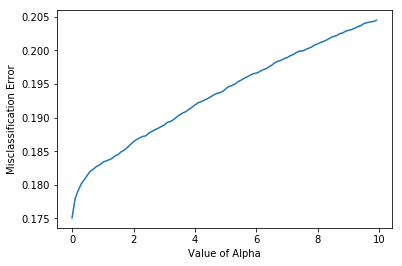

Training accuracy for Alpha = 0.001 is 82.49


In [44]:
# changing to misclassification error
MSE = [1 - x for x in scoref1_BoW]
# determining best k
optimal_alpha_BoW = alpha[MSE.index(min(MSE))]
print ("The optimal number alpha is %d" % optimal_alpha_BoW)

# plot misclassification error vs k
plt.plot(alpha, MSE)
plt.xlabel('Value of Alpha')
plt.ylabel('Misclassification Error')
plt.show()
print ("Training accuracy for Alpha =",optimal_alpha_BoW,'is',round(max(scoref1_BoW)*100,2) )

In [45]:
clf=BernoulliNB(alpha=optimal_alpha_BoW)
clf.fit( Xtrain, Ytrain)

BernoulliNB(alpha=0.001, binarize=0.0, class_prior=None, fit_prior=True)

In [46]:
pred_BoW=clf.predict(Xtest)

### Results

In [47]:
# http://fourier.eng.hmc.edu/e161/lectures/classification/node5.html
p,n=confusion_matrix(Ytest, pred_BoW)
TP=p[0]
FN=p[1]
FP=n[0]
TN=n[1]
P=TP+FN
N=FP+TN


print('Accuracy\t\t',round(accuracy_score(Ytest,pred_BoW,normalize=True)*100,2))
print("TPR (sestivity)\t\t", round(TP/P,2))
print("TNR (specificity)\t", round(TN/N,2))
print("FPR \t\t\t", round(FP/N,2))
print("FNR \t\t\t", round(FN/P,2))

target_names = ['Negative', 'Positive']
print(classification_report(Ytest, pred_BoW, target_names=target_names))

Accuracy		 81.38
TPR (sestivity)		 0.61
TNR (specificity)	 0.88
FPR 			 0.12
FNR 			 0.39
             precision    recall  f1-score   support

   Negative       0.61      0.61      0.61     28431
   Positive       0.88      0.88      0.88     89748

avg / total       0.81      0.81      0.81    118179



In [48]:
confusion_matrix(Ytest, pred_BoW)

array([[17201, 11230],
       [10771, 78977]])

## Feature importance using BoW

In [49]:
# https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-100:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))

In [50]:
positivetop10= print_top10(vectorizer, clf,'1')

1: used eat found after food tea were any what im which there do am try even now better by coffee ive because your buy tried been well make price little dont time use an find also much too about we really amazon no up would best some only other get out had me than will more has product flavor when from can love all if taste its one them or just be very at these great good they as like was so not on you are that have but with my in for of it is this to and the


# TF-IDF

In [14]:
# from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer()
Xtrain_tf_idf = tf_idf_vect.fit_transform(X_train.values)
Xtest_tf_idf = tf_idf_vect.transform(X_test.values)

In [52]:
score_tfid = [] 
alpha_tfid = np.arange(0.001,10,0.1)
# alpha.shape
for Alpha in alpha:
    clf=BernoulliNB(alpha=Alpha)
    scores = cross_val_score(clf, Xtrain, Ytrain, cv=10, scoring='accuracy')    
#     print('Aplha =',round(Alpha,5),'\t\t\tScore =',round(scores.mean(),5))
    
    score_tfid.append(scores.mean())

The optimal number alpha is 0


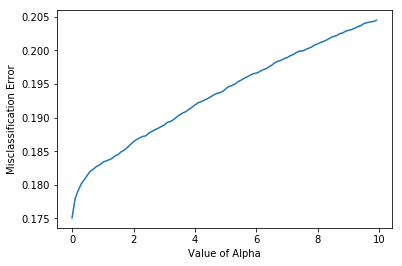

Training accuracy for Alpha = 0.001 is 82.49


In [53]:
# changing to misclassification error
MSE = [1 - x for x in score_tfid]

optimal_alpha_tfid = alpha_tfid[MSE.index(min(MSE))]
print ("The optimal number alpha is %d" % optimal_alpha_tfid)

plt.plot(alpha, MSE)
plt.xlabel('Value of Alpha')
plt.ylabel('Misclassification Error')
plt.show()
print ("Training accuracy for Alpha =",optimal_alpha_tfid,'is',round(max(score_tfid)*100,2) )

In [54]:
clf_tfid=BernoulliNB(alpha=optimal_alpha_tfid)
clf_tfid.fit(Xtrain_tf_idf, Ytrain)

BernoulliNB(alpha=0.001, binarize=0.0, class_prior=None, fit_prior=True)

In [57]:
pred_tfid=clf_tfid.predict(Xtest_tf_idf)

In [58]:
confusion_matrix(Ytest, pred_tfid)

array([[17201, 11230],
       [10771, 78977]])

In [59]:
p_tfid,n_tfid=confusion_matrix(Ytest, pred_tfid)
TP_tfid=p_tfid[0]
FN_tfid=p_tfid[1]
FP_tfid=n_tfid[0]
TN_tfid=n_tfid[1]
P_tfid=TP_tfid+FN_tfid
N_tfid=FP_tfid+TN_tfid

print('Accuracy\t\t',round(accuracy_score(Ytest,pred_tfid,normalize=True)*100,2))
print("TPR (sestivity)\t\t", round(TP_tfid/P_tfid,2))
print("TNR (specificity)\t", round(TN_tfid/N_tfid,2))
print("FPR \t\t\t", round(FP_tfid/N_tfid,2))
print("FNR \t\t\t", round(FN_tfid/P_tfid,2))

target_names = ['Negative', 'Positive']
print(classification_report(Ytest, pred_tfid, target_names=target_names))

Accuracy		 81.38
TPR (sestivity)		 0.61
TNR (specificity)	 0.88
FPR 			 0.12
FNR 			 0.39
             precision    recall  f1-score   support

   Negative       0.61      0.61      0.61     28431
   Positive       0.88      0.88      0.88     89748

avg / total       0.81      0.81      0.81    118179



In [60]:
positivetop10= print_top10(tf_idf_vect, clf_tfid,'0')

0: used eat found after food tea were any what im which there do am try even now better by coffee ive because your buy tried been well make price little dont time use an find also much too about we really amazon no up would best some only other get out had me than will more has product flavor when from can love all if taste its one them or just be very at these great good they as like was so not on you are that have but with my in for of it is this to and the
